In [1]:
import csv
import itertools
import os
import random
import sys


def read_students(start_index=0, count=50, filepath="records.csv"):
    """Read up to count students starting from start_index (after header).
    Returns a list of student dicts with keys: tutorial group, id, school, name, gender, gpa
    """
    students = []

    with open(filepath, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader, None)  # skip header if present

        # skip start_index rows
        for _ in range(start_index):
            try:
                next(reader)
            except StopIteration:
                return students

        for _ in range(count):
            try:
                row = next(reader)
            except StopIteration:
                break

            try:
                gpa = float(row[5])
            except Exception:
                # skip rows with non-numeric GPA
                continue

            student = {
                'tutorial group': row[0].strip(),
                'id': row[1].strip(),
                'school': row[2].strip(),
                'name': row[3].strip(),
                'gender': row[4].strip(),
                'gpa': gpa,
            }
            students.append(student)

    return students
    
read_students(start_index=0, count=50, filepath="records.csv")


[{'tutorial group': 'G-1',
  'id': '5002',
  'school': 'CCDS',
  'name': 'Aarav Singh',
  'gender': 'Male',
  'gpa': 4.02},
 {'tutorial group': 'G-1',
  'id': '3838',
  'school': 'EEE',
  'name': 'Aarti Nair',
  'gender': 'Female',
  'gpa': 4.05},
 {'tutorial group': 'G-1',
  'id': '2091',
  'school': 'EEE',
  'name': 'Adlan Bin Rahman',
  'gender': 'Male',
  'gpa': 4.2},
 {'tutorial group': 'G-1',
  'id': '288',
  'school': 'CoB (NBS)',
  'name': 'Ajay Verma',
  'gender': 'Male',
  'gpa': 4.01},
 {'tutorial group': 'G-1',
  'id': '4479',
  'school': 'CCDS',
  'name': 'Amelia Kim',
  'gender': 'Female',
  'gpa': 4.11},
 {'tutorial group': 'G-1',
  'id': '5708',
  'school': 'SoH',
  'name': 'Ananya Ramesh',
  'gender': 'Male',
  'gpa': 4.2},
 {'tutorial group': 'G-1',
  'id': '4563',
  'school': 'WKW SCI',
  'name': 'Anjali Patel',
  'gender': 'Female',
  'gpa': 4.01},
 {'tutorial group': 'G-1',
  'id': '3989',
  'school': 'WKW SCI',
  'name': 'Anthony Liu',
  'gender': 'Male',
  'gpa':

In [2]:
def count_total_students(filepath="records.csv"):
    """Count total number of student records (excluding header)."""
    if not os.path.exists(filepath):
        return 0
        
    with open(filepath, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader, None)  # skip header
        return sum(1 for row in reader)

        
count_total_students(filepath="records.csv")


6000

In [6]:
def form_groups(students, num_groups=10):
    """Form groups from a list of student dicts.
    Returns list of groups (each group is a list of students).
    """
    if not students:
        return []

    students_sorted = sorted(students, key=lambda x: x['gpa'], reverse=True)

    # split into up to 5 bands as evenly as possible
    n = len(students_sorted)
    band_size = max(1, n // 5)
    bands = [students_sorted[i:i + band_size] for i in range(0, n, band_size)]

    # split each band by gender
    band_males = []
    band_females = []
    for band in bands:
        males = [s for s in band if s['gender'].strip().lower() in ('m', 'male')]
        females = [s for s in band if s['gender'].strip().lower() in ('f', 'female')]
        random.shuffle(males)
        random.shuffle(females)
        band_males.append(males)
        band_females.append(females)

    total_males = sum(len(m) for m in band_males)
    total_females = sum(len(f) for f in band_females)

    if total_males > total_females:
        target_males_per_group, target_females_per_group = 3, 2
    else:
        target_males_per_group, target_females_per_group = 2, 3

    groups = [[] for _ in range(num_groups)]
    male_count = [0] * num_groups
    female_count = [0] * num_groups

    # distribute one student from each band into each group
    for band_idx in range(len(bands)):
        for group_idx in range(num_groups):
            # try to pick a student to respect the gender targets
            picked = False
            if male_count[group_idx] < target_males_per_group and band_males[band_idx]:
                groups[group_idx].append(band_males[band_idx].pop())
                male_count[group_idx] += 1
                picked = True
            elif female_count[group_idx] < target_females_per_group and band_females[band_idx]:
                groups[group_idx].append(band_females[band_idx].pop())
                female_count[group_idx] += 1
                picked = True
            elif band_males[band_idx]:
                groups[group_idx].append(band_males[band_idx].pop())
                male_count[group_idx] += 1
                picked = True
            elif band_females[band_idx]:
                groups[group_idx].append(band_females[band_idx].pop())
                female_count[group_idx] += 1
                picked = True

    return groups

form_groups(students, num_groups=10)


In [23]:
def print_groups(groups, students_sorted, bands, batch_number=1):
    """Print groups with band information."""
    # Precompute band assignments for faster lookup
    student_to_band = {}
    for band_idx, band in enumerate(bands):
        for student in band:
            # Use a unique identifier (name + id) to handle duplicate names
            student_key = f"{student['name']}_{student['id']}"
            student_to_band[student_key] = band_idx + 1  # Band 1 = highest GPA

    print(f"=== BATCH {batch_number} ===")
    print(f"Total students in this batch: {len(students_sorted)}")
    print()
    
    for i, g in enumerate(groups, 1):
        print(f"Group {i}:")
        males_in_group = 0
        females_in_group = 0
        total_gpa = 0.0
        
        for student in g:
            # Determine which band the student came from
            student_key = f"{student['name']}_{student['id']}"
            band_number = student_to_band.get(student_key, "Unknown")
            
            gender_lower = student['gender'].lower()
            if gender_lower in ['m','male']:
                males_in_group += 1
            elif gender_lower in ['f', 'female']:
                females_in_group += 1
            total_gpa += student['gpa']
            print(f"  {student['name']} | {student['school']} | {student['gender']} | GPA: {student['gpa']:.2f} | Band: {band_number}")
        
        if g:
            avg_gpa = total_gpa / len(g)
            print(f"  Summary: {males_in_group} males, {females_in_group} females, Average GPA: {avg_gpa:.2f}")
        else:
            print("  Summary: Empty group")

print_groups(groups, students_sorted, bands, batch_number=1)

=== BATCH 1 ===
Total students in this batch: 50

Group 1:


TypeError: 'float' object is not subscriptable

In [30]:

def save_groups_to_csv(all_groups_data, output_file="student_groups.csv"):
    """Save all groups data to a CSV file.
    
    Args:
        all_groups_data: List of tuples (batch_number, groups, students_sorted, bands)
        output_file: Name of the output CSV file
    """
    try:
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            
            # Write header
            writer.writerow([
                'Batch', 'Group', 'Student_Name', 'Student_ID', 'School', 
                'Gender', 'GPA', 'Band', 'Tutorial_Group'
            ])
            
            # Precompute band assignments for each batch and write data
            for batch_number, groups, students_sorted, bands in all_groups_data:
                # Create band lookup for this batch
                student_to_band = {}
                for band_idx, band in enumerate(bands):
                    for student in band:
                        student_key = f"{student['name']}_{student['id']}"
                        student_to_band[student_key] = band_idx + 1
                
                # Write groups for this batch
                for group_idx, group in enumerate(groups, 1):
                    for student in group:
                        student_key = f"{student['name']}_{student['id']}"
                        band_number = student_to_band.get(student_key, "Unknown")
                        
                        writer.writerow([
                            batch_number,
                            f"Group {group_idx}",
                            student['name'],
                            student['id'],
                            student['school'],
                            student['gender'],
                            f"{student['gpa']:.2f}",
                            band_number,
                            student['tutorial group']
                        ])
        
        print(f"All groups have been saved to '{output_file}'")
        return True
        
    except Exception as e:
        print(f"Error saving to CSV file: {e}")
        return False


In [29]:
if __name__ == "__main__":
    BATCH_SIZE = 50
    NUM_GROUPS = 10
    
    try:
        # Count total students first
        total_students = count_total_students()
        if total_students == 0:
            print("No student records found in the file.")
            sys.exit(1)
            
        print(f"Total students in file: {total_students}")
        print(f"Processing in batches of {BATCH_SIZE} students...")
        print("=" * 60)
        
        batch_number = 1
        start_index = 0
        
        # Process file in batches until all students are processed
        while True:
            print(f"Reading batch {batch_number} (students {start_index + 1} to {start_index + BATCH_SIZE})...")
            students = read_students(start_index, BATCH_SIZE)
            
            if not students:
                print("No more students to process.")
                break
                
            print(f"Processing {len(students)} students in batch {batch_number}...")
            
            # Sort students for band creation
            students_sorted = sorted(students, key=lambda x: x['gpa'], reverse=True)
            n = len(students_sorted)
            band_size = max(1, n // 5)
            bands = [students_sorted[i:i + band_size] for i in range(0, n, band_size)]

            # Form groups for this batch
            groups = form_groups(students, num_groups=NUM_GROUPS)
            
            # Print groups for this batch
            print_groups(groups, students_sorted, bands, batch_number)
            
            # Update for next batch
            start_index += BATCH_SIZE
            batch_number += 1
            
            # Add separator between batches
            if start_index < total_students:
                print("=" * 60)
                print()
        
        print(f"Processing complete! Processed {batch_number - 1} batch(es) total.")
        
    except FileNotFoundError as e:
        print(e)
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred: {e}")
        sys.exit(1)



Total students in file: 6000
Processing in batches of 50 students...
Reading batch 1 (students 1 to 50)...
Processing 50 students in batch 1...
=== BATCH 1 ===
Total students in this batch: 50

Group 1:
  Adlan Bin Rahman | EEE | Male | GPA: 4.20 | Band: 1
  Henry Foster | EEE | Male | GPA: 4.11 | Band: 2
  Zara Chang | MSE | Female | GPA: 4.11 | Band: 3
  Isabella Thompson | CoB (NBS) | Female | GPA: 4.03 | Band: 4
  Anjali Patel | WKW SCI | Female | GPA: 4.01 | Band: 5
  Summary: 2 males, 3 females, Average GPA: 4.09

Group 2:
  Ananya Ramesh | SoH | Male | GPA: 4.20 | Band: 1
  Jett Morales | MAE | Male | GPA: 4.12 | Band: 2
  Han Li | MAE | Female | GPA: 4.10 | Band: 3
  Nhung Vu | ADM | Female | GPA: 4.04 | Band: 4
  Vivi Dwi | CoB (NBS) | Female | GPA: 3.95 | Band: 5
  Summary: 2 males, 3 females, Average GPA: 4.08

Group 3:
  Layla Torres | ASE | Female | GPA: 4.52 | Band: 1
  Darren Lee | CoE | Male | GPA: 4.12 | Band: 2
  Lucas Walker | MAE | Male | GPA: 4.06 | Band: 3
  Aarti

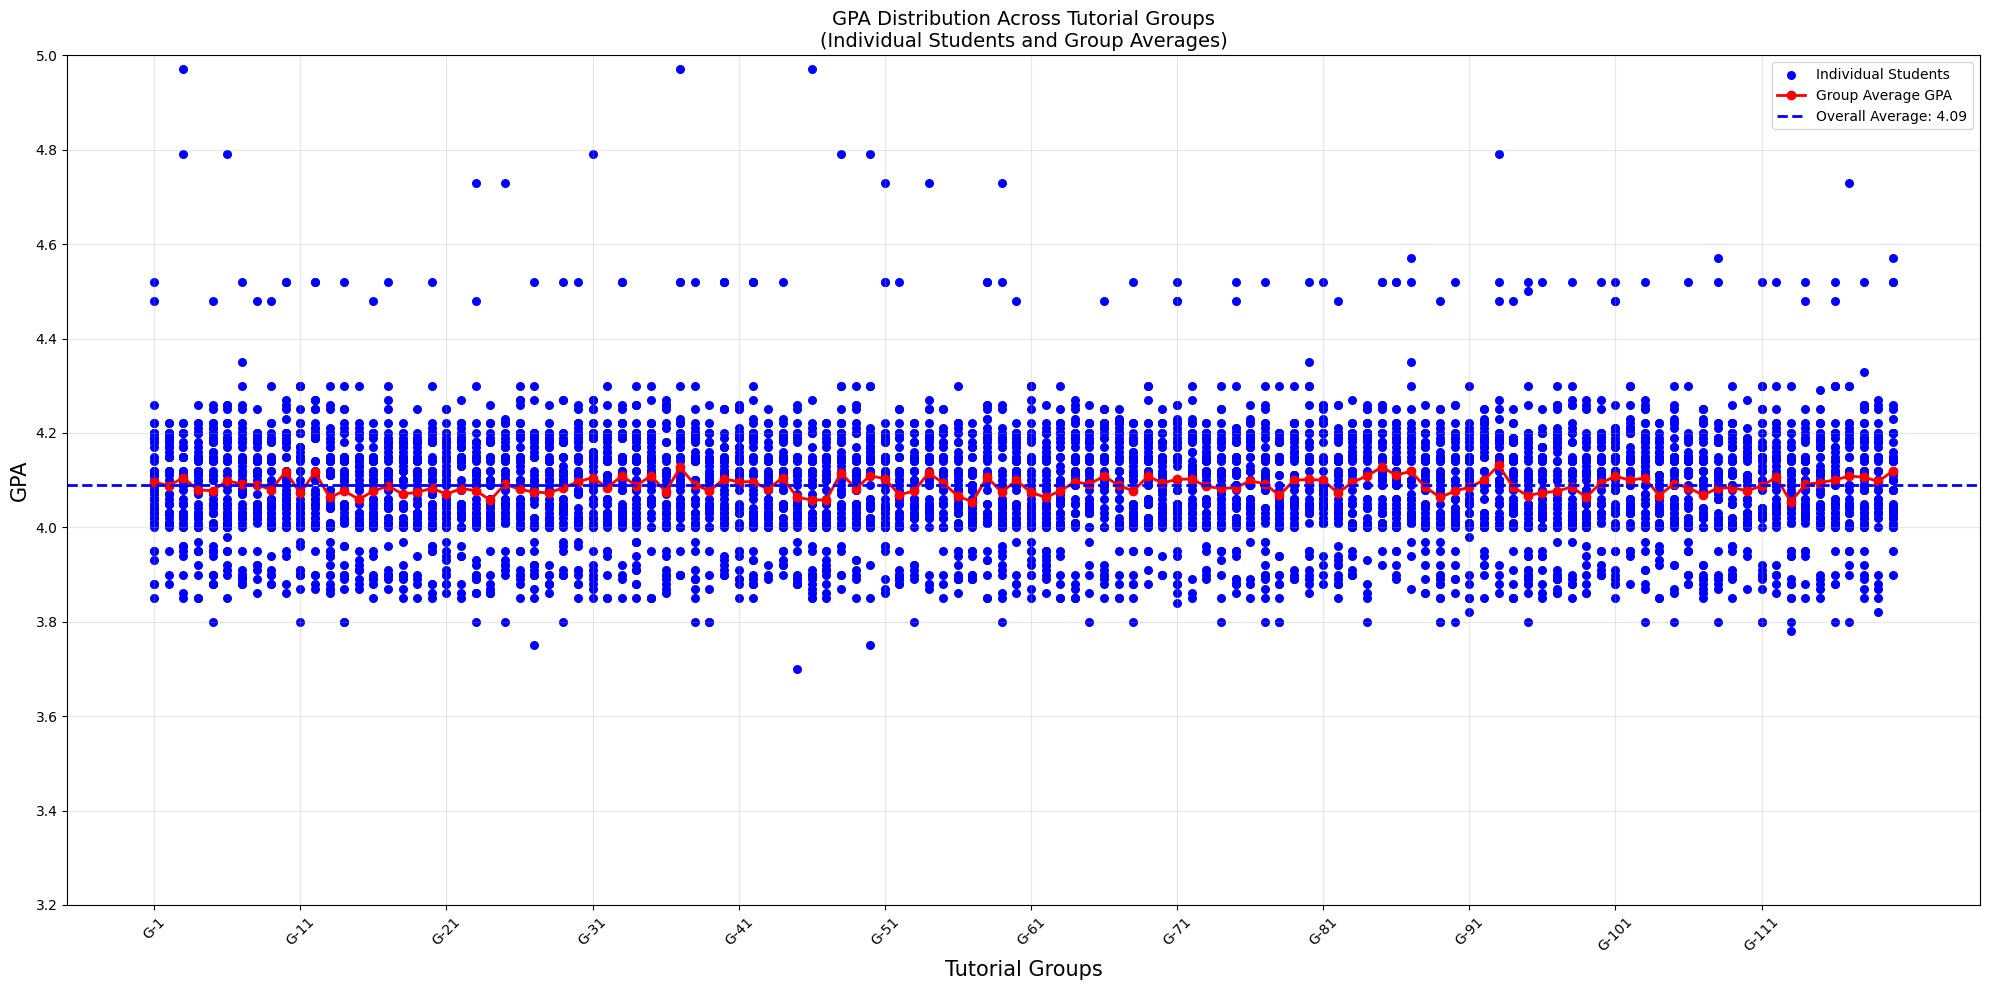

STATISTICAL SUMMARY
Total Students: 6000
Total Tutorial Groups: 120
Overall Average GPA: 4.089
Minimum GPA: 3.700
Maximum GPA: 4.970

Tutorial Group GPA Statistics:
Average group mean GPA: 4.089
Lowest group average: 4.054
Highest group average: 4.131

Sample Group Averages:
  G-1: 4.096
  G-2: 4.089
  G-3: 4.105
  G-4: 4.079
  G-5: 4.078
  ...
  G-118: 4.106
  G-119: 4.097
  G-120: 4.120


In [20]:
import matplotlib.pyplot as plt
import csv

# Read data from records.csv file
tutorial_groups = []
gpas = []

with open('records.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        tutorial_groups.append(row['Tutorial Group'])
        gpas.append(float(row['CGPA']))  # Using CGPA column for GPA

# Organize data by tutorial group
group_data = {}
for i, group in enumerate(tutorial_groups):
    if group not in group_data:
        group_data[group] = []
    group_data[group].append(gpas[i])

# Calculate statistics for each tutorial group
sorted_groups = sorted(group_data.keys(), key=lambda x: int(x.split('-')[1]))
group_means = []
group_mins = []
group_maxs = []
all_student_gpas = []

# Prepare data for plotting
x_positions = []
y_gpas = []
group_labels = []

for i, group in enumerate(sorted_groups):
    group_gpas = group_data[group]
    
    # Add individual student points
    for gpa in group_gpas:
        x_positions.append(i)
        y_gpas.append(gpa)
        all_student_gpas.append(gpa)
    
    # Calculate group statistics
    group_means.append(sum(group_gpas) / len(group_gpas))
    group_mins.append(min(group_gpas))
    group_maxs.append(max(group_gpas))
    group_labels.append(group)

# Create the visualization
plt.figure(figsize=(20, 10))

# Plot individual student GPAs as scatter points with transparency
plt.scatter(x_positions, y_gpas, alpha=1.0, color='blue', s=30, label='Individual Students')

# Plot tutorial group average GPAs as red line
plt.plot(range(len(sorted_groups)), group_means, 'ro-', 
         linewidth=2, markersize=6, label='Group Average GPA')

# Customize the plot
plt.xlabel('Tutorial Groups', fontsize=15)
plt.ylabel('GPA', fontsize=15)
plt.title('GPA Distribution Across Tutorial Groups\n(Individual Students and Group Averages)', fontsize=14)

# Set x-axis labels to show every 10th tutorial group for readability
x_ticks = list(range(0, len(sorted_groups), 10))
x_labels = [sorted_groups[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45)

# Set y-axis range from min_gpa-0.5 to 5
min_gpa = min(all_student_gpas)
plt.ylim(min_gpa - 0.5, 5.0)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Add horizontal line for overall average
overall_mean = sum(all_student_gpas) / len(all_student_gpas)
plt.axhline(y=overall_mean, color='blue', linestyle='--', 
            linewidth=2, alpha=1.0, label=f'Overall Average: {overall_mean:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# Print statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(f"Total Students: {len(all_student_gpas)}")
print(f"Total Tutorial Groups: {len(sorted_groups)}")
print(f"Overall Average GPA: {overall_mean:.3f}")
print(f"Minimum GPA: {min(all_student_gpas):.3f}")
print(f"Maximum GPA: {max(all_student_gpas):.3f}")

# Print group statistics
print(f"\nTutorial Group GPA Statistics:")
print(f"Average group mean GPA: {sum(group_means)/len(group_means):.3f}")
print(f"Lowest group average: {min(group_means):.3f}")
print(f"Highest group average: {max(group_means):.3f}")

# Show some sample groups with their averages
print(f"\nSample Group Averages:")
for i in range(min(5, len(sorted_groups))):
    print(f"  {sorted_groups[i]}: {group_means[i]:.3f}")
if len(sorted_groups) > 5:
    print("  ...")
    for i in range(len(sorted_groups)-3, len(sorted_groups)):
        print(f"  {sorted_groups[i]}: {group_means[i]:.3f}")